In [1]:
import time

import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models import ResNet50_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops.boxes import nms
from tqdm import tqdm

from dataset import PlatesDataset, CarPlates, MultiDataset

In [2]:
train_dataset_numbers = PlatesDataset('data/train/')
train_dataset_cars = CarPlates(root='data\\car_plates\\')
full_dataset = MultiDataset(datasets=[train_dataset_numbers, train_dataset_cars])
valid_dataset = PlatesDataset('data/test/')

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

list(next(iter(train_dataset)))[0].shape

torch.Size([3, 105, 215])

In [23]:
from torchvision.models import MobileNet_V3_Large_Weights


def create_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(
        weights_backbone=MobileNet_V3_Large_Weights.IMAGENET1K_V1,
        trainable_backbone_layers=1)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# def create_model(num_classes):
#     model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(weights_backbone=MobileNet_V3_Large_Weights.IMAGENET1K_V1,
#                                                                        num_classes=2, trainable_backbone_layers=1)
#     return model

def collate_fn(batch):
    return tuple(zip(*batch))

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_classes=2).to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.3)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)

In [25]:
from metric import MetricCounter


def train(train_dataloader, model):
    model.train()
    running_loss = 0
    with tqdm(total=len(train_dataloader)) as t:
        for i, data in enumerate(train_dataloader):
            optimizer.zero_grad()
            images, targets = data[0], data[1]
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            t.update(1)
            t.set_postfix_str(f'Loss: {running_loss / (i + 1)}')

    train_loss = running_loss / len(train_dataloader.dataset)
    return train_loss


def val(val_dataloader, mc: MetricCounter, model=None):
    model.eval()
    with tqdm(total=len(val_dataloader)) as t:
        for i, data in enumerate(val_dataloader):
            images, targets = data[0], data[1]
            images = [image.to(device) for image in images]
            true_boxes = torch.concat([target['boxes'] for target in targets], dim=0)
            true_labels = torch.concat([target['labels'] for target in targets], dim=0)
            output = model(images)
            pred_boxes = torch.concat([box['boxes'] for box in output], dim=0)
            pred_labels = torch.concat([label['labels'] for label in output], dim=0)
            scores = torch.concat([score['scores'] for score in output], dim=0)
            true_boxes = true_boxes.detach().to(device)
            pred_boxes = pred_boxes.detach().to(device)
            pred_labels = pred_labels.detach().to(device)
            true_labels = true_labels.detach().to(device)
            scores = scores.detach().to(device)
            mc.update(true_boxes, true_labels, pred_boxes, pred_labels, scores)
            t.update(1)
            metrics = mc.get_metric(metric_name='all')
            t.set_description(
                f'mAP: {metrics["map"]}| IoU: {metrics["IoU"]} | precision: {metrics["precision"]} | recall: {metrics["recall"]}')


In [26]:
train_losses = []

CHECKPOINTS_PATH = 'checkpoints/'

best_mAP = 0

map_hist = list()
precision_hist = list()
recall_hist = list()
IoU_hist = list()
try:
    for epoch in range(1):
        metric_counter = MetricCounter()
        start = time.time()
        train_loss = train(train_data_loader, model)
        val(test_data_loader, metric_counter, model)
        scheduler.step()
        end = time.time()
        train_losses.append(train_loss)
        metric_epoch = metric_counter.get_metric(metric_name='all')
        map_hist.append(metric_epoch['map'])
        precision_hist.append(metric_epoch['precision'])
        recall_hist.append(metric_epoch['recall'])
        IoU_hist.append(metric_epoch['IoU'])
        if metric_epoch['map'] > best_mAP:
            best_path_model = f"{CHECKPOINTS_PATH}_{round(metric_epoch['map'], 3)}_{epoch + 1}a_epochs.pt"
            torch.save(
                model.state_dict(),
                best_path_model)
            best_mAP = metric_epoch['map']
except KeyboardInterrupt:
    print('Прервано пользователем')

mAP: 0.03444361123942524| IoU: 0.12038668187589673 | precision: 0.010057949473222427 | recall: 0.8804347826086957:   5%|▌         | 46/846 [00:36<10:39,  1.25it/s] 

Прервано пользователем


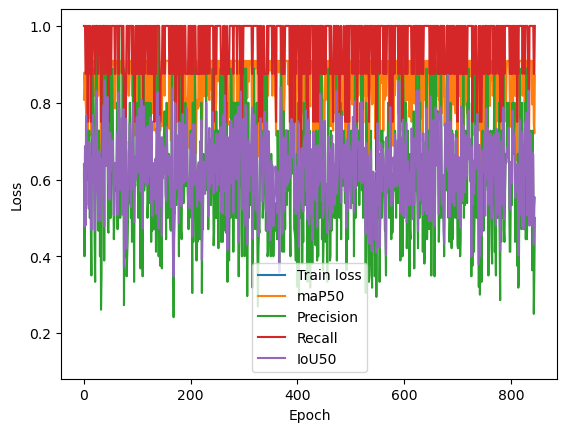

In [16]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train loss')
ax.plot(map_hist, label='maP50')
ax.plot(precision_hist, label='Precision')
ax.plot(recall_hist, label='Recall')
ax.plot(IoU_hist, label='IoU50')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

In [20]:
model.load_state_dict(torch.load('C:\\MySpace\\Projects\\GenerImages\\lab2\\checkpoints\\_0.861_3a_epochs.pt'))
metric_counter = MetricCounter()
val(test_data_loader, metric_counter, model)
metrics = metric_counter.get_metric('all')
f'mAP: {metrics["map"]}| IoU: {metrics["IoU"]} | precision: {metrics["precision"]} | recall: {metrics["recall"]}'

mAP: 0.847726990007554| IoU: 0.7095962948625134 | precision: 0.7436527433294675 | recall: 0.9396551724137931:  14%|█▎        | 116/846 [00:09<01:02, 11.67it/s] 


KeyboardInterrupt: 

In [ ]:
from PIL import Image


def draw_predict(img_path: str, iou_threshold=0.1, threshold=0., scale_percent=25):
    model.eval()
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_ = torch.tensor(img).permute(2, 0, 1).to(torch.float).to(device) / 255
    img_ = torch.unsqueeze(img_, dim=0)
    predict = model(img_)
    ind = nms(predict[0]['boxes'], predict[0]['scores'], iou_threshold).detach().cpu().numpy()
    for i, box in enumerate(predict[0]['boxes'][ind]):
        if predict[0]['scores'][i] > threshold:
            img = cv2.rectangle(img,
                                (int(box[0]), int(box[1])),
                                (int(box[2]), int(box[3])),
                                (255, 0, 0), 3)
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim)
    return Image.fromarray(img)


draw_predict('C:\\MySpace\\Projects\\GenerImages\\lab2\\data\\car_plates\\images\\Cars6.png', 0, scale_percent=100,
             threshold=0.7)

In [ ]:
draw_predict('C:\\MySpace\\Projects\\GenerImages\\lab2\\photo_2022-11-30_17-15-22.jpg', 0, scale_percent=100,
             threshold=0.7)

In [ ]:
draw_predict('C:\\MySpace\\Projects\\GenerImages\\lab2\\photo_2022-11-30_17-15-26.jpg', 0, scale_percent=100)

In [ ]:
draw_predict('C:\\MySpace\\Projects\\GenerImages\\lab2\\photo_2022-11-30_17-15-28.jpg', 0, scale_percent=100,
             threshold=0.4)

In [ ]:
def create_model_resnet50(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights_backbone=ResNet50_Weights.IMAGENET1K_V1,
                                                                 trainable_backbone_layers=1)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
model = create_model_resnet50(2).to(device=device)
model.load_state_dict(torch.load('C:\\MySpace\\Projects\\GenerImages\\lab2\\checkpoints\\_0.848_5_epochs.pt'))

In [ ]:
draw_predict('C:\\MySpace\\Projects\\GenerImages\\lab2\\photo_2022-11-30_17-15-28.jpg', 0, scale_percent=100, threshold=0.4)

In [ ]:
draw_predict('C:\\MySpace\\Projects\\GenerImages\\lab2\\photo_2022-11-30_17-15-26.jpg', 0, scale_percent=100)